In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

### 1. Data Cleaning

In [2]:
df = pd.read_csv("diabetes.csv")

In [3]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [5]:
duplicate_rows_data = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape[0])

number of duplicate rows:  3854


In [6]:
df = df.drop_duplicates()

In [7]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [8]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

gender: 3 distinct values
age: 102 distinct values
hypertension: 2 distinct values
heart_disease: 2 distinct values
smoking_history: 6 distinct values
bmi: 4247 distinct values
HbA1c_level: 18 distinct values
blood_glucose_level: 18 distinct values
diabetes: 2 distinct values


In [9]:
df.describe().style.format("{:.2f}")

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96146.00,96146.00,96146.00,96146.00,96146.00,96146.00,96146.00
mean,41.79,0.08,0.04,27.32,5.53,138.22,0.09
std,22.46,0.27,0.20,6.77,1.07,40.91,0.28
min,0.08,0.00,0.00,10.01,3.50,80.00,0.00
25%,24.00,0.00,0.00,23.40,4.80,100.00,0.00
50%,43.00,0.00,0.00,27.32,5.80,140.00,0.00
75%,59.00,0.00,0.00,29.86,6.20,159.00,0.00
max,80.00,1.00,1.00,95.69,9.00,300.00,1.00


In [10]:
non_integer_ages = df[df['age'] % 1 != 0]
non_integer_ages

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
155,Female,0.08,0,0,No Info,14.43,6.5,160,0
218,Female,0.56,0,0,No Info,16.85,5.0,140,0
241,Male,0.88,0,0,No Info,17.49,6.0,140,0
268,Female,0.16,0,0,No Info,12.15,6.6,100,0
396,Male,0.16,0,0,No Info,14.35,6.5,126,0
...,...,...,...,...,...,...,...,...,...
99536,Female,0.40,0,0,No Info,16.66,3.5,140,0
99629,Female,0.64,0,0,No Info,17.58,6.1,140,0
99778,Female,0.32,0,0,No Info,12.26,5.8,126,0
99911,Female,0.32,0,0,No Info,18.37,3.5,80,0


In [11]:
df = df[df["age"] % 1 == 0]
df.shape

(94133, 9)

In [12]:
df["gender"].value_counts()

gender
Female    55176
Male      38939
Other        18
Name: count, dtype: int64

In [13]:
df = df[df["gender"] != "Other"]

In [14]:
df["smoking_history"].value_counts()

smoking_history
never          34261
No Info        31024
former          9299
current         9192
not current     6342
ever            3997
Name: count, dtype: int64

In [15]:
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

# Apply the function to the 'smoking_history' column
df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)

df['smoking_history'].value_counts()

smoking_history
non-smoker     65285
past_smoker    19638
current         9192
Name: count, dtype: int64

### 3. Data preparation

In [16]:
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})
df = pd.get_dummies(columns=['smoking_history'], drop_first=True, data = df)

In [17]:
X = df.drop('diabetes', axis=1)  
y = df['diabetes']               

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4. Model Building

#### 4.1 Logistic Regression

Confusion Matrix:
[[16957   141]
 [  641  1084]]


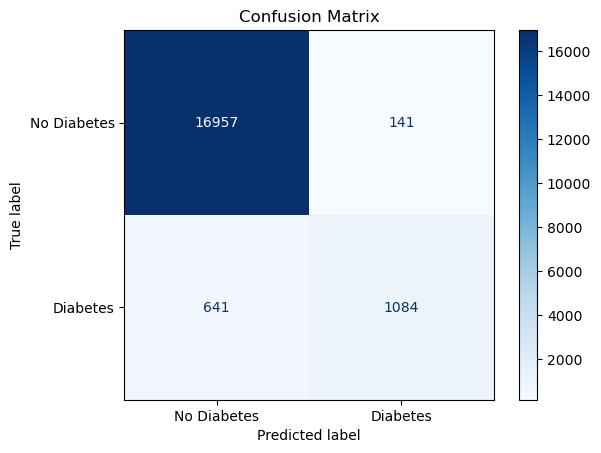


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17098
           1       0.88      0.63      0.73      1725

    accuracy                           0.96     18823
   macro avg       0.92      0.81      0.86     18823
weighted avg       0.96      0.96      0.96     18823

Accuracy: 0.96
Precision: 0.88
Recall: 0.63
F1 Score: 0.73


In [19]:
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix:")
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['No Diabetes', 'Diabetes'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr):.2f}")

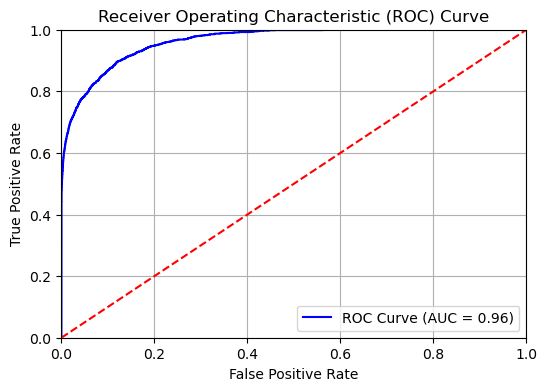

In [20]:
# ROC AUC
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

plot_roc_curve(log_reg, X_test_scaled, y_test)

In [21]:
# Grid Search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],        # Regularization 
}

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_scaled, y_train)

# Best Parameters
print("\nBest Parameters from GridSearchCV:")
print(grid_search.best_params_)
print(f"Best Cross-Validation Score: {grid_search.best_score_:.2f}")


Best Parameters from GridSearchCV:
{'C': 100, 'penalty': 'l1'}
Best Cross-Validation Score: 0.63


In [ ]:
# Random Search
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(log_reg, param_grid, n_iter=7, cv=5, random_state=42)
random_search.fit(X_train_scaled, y_train)

print("\nBest Parameters from RandomizedSearchCV:")
print(random_search.best_params_)
print(f"Best Cross-Validation Score: {random_search.best_score_:.2f}")


Best Parameters from RandomizedSearchCV:
{'penalty': 'l2', 'C': 10}
Best Cross-Validation Score: 0.89


In [22]:
from sklearn.model_selection import cross_val_score

best_lr_classifier = grid_search.best_estimator_
cv_scores = cross_val_score(best_lr_classifier, X_train_scaled, y_train, cv=5, scoring='recall')

# Cross-validation scores
print("Cross-Validation AUC Scores:", cv_scores)
print(f"Mean Cross-Validation AUC: {cv_scores.mean():.2f}")

Cross-Validation AUC Scores: [0.63609467 0.62573964 0.64396743 0.62324204 0.5980755 ]
Mean Cross-Validation AUC: 0.63


In [23]:
# Feature importance
feature_names = X_train.columns

coefficients = best_lr_classifier.coef_[0]

lr_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance (Coefficient)': coefficients
}).sort_values(by='Importance (Coefficient)', key=abs, ascending=False)

lr_importance_df.reset_index(drop=True, inplace=True)
lr_importance_df

,Feature,Importance (Coefficient)
0,HbA1c_level,12.763175
1,bmi,7.387766
2,blood_glucose_level,7.281034
3,age,3.643394
4,hypertension,0.756860
5,heart_disease,0.721341
6,smoking_history_non-smoker,-0.311812
7,gender,0.236129
8,smoking_history_past_smoker,-0.105514


#### 4.2 Decision Tree

Confusion Matrix:
[[16568   530]
 [  460  1265]]


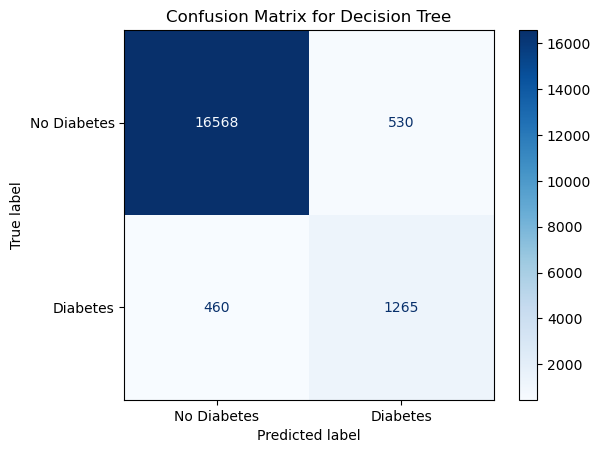


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     17098
           1       0.70      0.73      0.72      1725

    accuracy                           0.95     18823
   macro avg       0.84      0.85      0.84     18823
weighted avg       0.95      0.95      0.95     18823

Accuracy: 0.95
Precision: 0.70
Recall: 0.73
F1 Score: 0.72


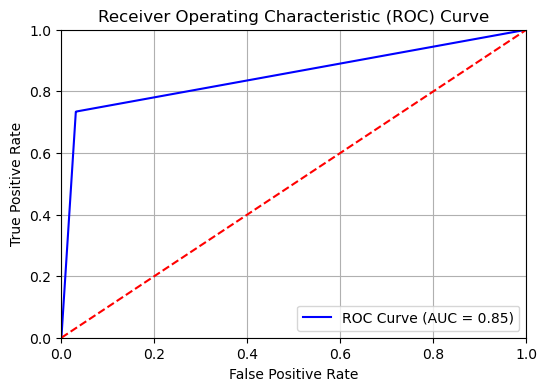

In [24]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_scaled, y_train)

y_pred_dt = dt_classifier.predict(X_test_scaled)

# Confusion Matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:")
print(conf_matrix_dt)

disp_dt = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_dt, 
                                  display_labels=['No Diabetes', 'Diabetes'])
disp_dt.plot(cmap='Blues')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

# Results
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_dt):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_dt):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_dt):.2f}")

plot_roc_curve(dt_classifier, X_test_scaled, y_test)

In [25]:
# GridSearch
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV
grid_search_dt = GridSearchCV(estimator=dt_classifier, 
                           param_grid=param_grid, 
                           cv=5,  
                           n_jobs=-1, 
                           scoring='recall')

# Fit the model
grid_search_dt.fit(X_train_scaled, y_train)

# Best Parameters
print("\nBest Parameters from GridSearchCV:")
print(grid_search_dt.best_params_)
print(f"Best Cross-Validation Score: {grid_search_dt.best_score_:.2f}")

print("Best Parameters:", grid_search_dt.best_params_)


Best Parameters from GridSearchCV:
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Score: 0.74
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [27]:
# Cross-validation
best_dt_classifier = grid_search_dt.best_estimator_
cv_scores = cross_val_score(best_dt_classifier, X_train_scaled, y_train, cv=5, scoring='recall')

# Print cross-validation scores
print("Cross-Validation AUC Scores:", cv_scores)
print(f"Mean Cross-Validation AUC: {cv_scores.mean():.2f}")

Cross-Validation AUC Scores: [0.75147929 0.72559172 0.74685418 0.74833457 0.72612879]
Mean Cross-Validation AUC: 0.74


In [28]:
# Feature Importance

def get_feature_importance(model, feature_names):
    importance = model.feature_importances_

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    importance_df.reset_index(drop=True, inplace=True)
    return importance_df


dt_importance_df = get_feature_importance(best_dt_classifier, X_train.columns)
dt_importance_df 

,Feature,Importance
0,HbA1c_level,0.493710
1,blood_glucose_level,0.266237
2,bmi,0.126177
3,age,0.071495
4,gender,0.012826
5,smoking_history_non-smoker,0.009902
6,smoking_history_past_smoker,0.009738
7,hypertension,0.006022
8,heart_disease,0.003895


#### 4.3 Random Forest

Confusion Matrix:
[[17028    70]
 [  526  1199]]


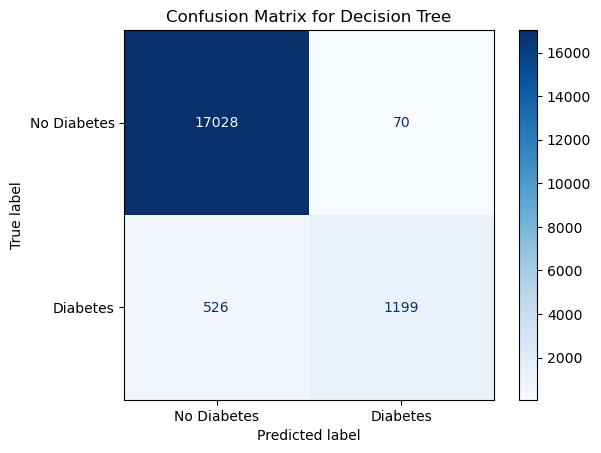


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17098
           1       0.94      0.70      0.80      1725

    accuracy                           0.97     18823
   macro avg       0.96      0.85      0.89     18823
weighted avg       0.97      0.97      0.97     18823

Accuracy: 0.97
Precision: 0.94
Recall: 0.70
F1 Score: 0.80


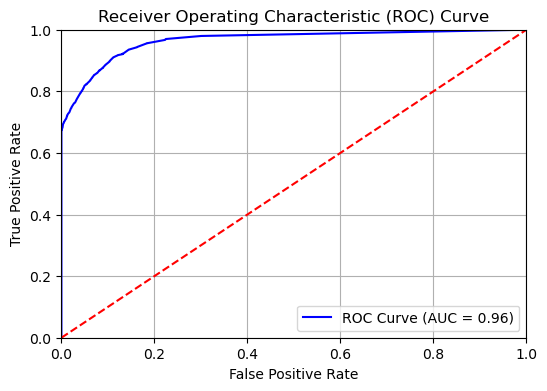

In [29]:
# Model Evaluation
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

y_pred_rf = rf_classifier.predict(X_test_scaled)

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(conf_matrix_rf)

disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, 
                                  display_labels=['No Diabetes', 'Diabetes'])
disp_rf.plot(cmap='Blues')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

# Results
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.2f}")

plot_roc_curve(rf_classifier, X_test_scaled, y_test)

In [31]:
# Random Search
from sklearn.model_selection import RandomizedSearchCV

rf_param_grid = {
    'n_estimators': [20, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

random_search_rf = RandomizedSearchCV(rf_classifier, rf_param_grid, n_iter=5, cv=5, random_state=42, scoring='recall')
random_search_rf.fit(X_train_scaled, y_train)

print("\nBest Parameters from RandomizedSearchCV:")
print(random_search_rf.best_params_)
print(f"Best Cross-Validation Score: {random_search_rf.best_score_:.2f}")


Best Parameters from RandomizedSearchCV:
{'n_estimators': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'criterion': 'entropy'}
Best Cross-Validation Score: 0.68


In [32]:
# Cross-validation
best_rf_classifier = random_search_rf.best_estimator_
cv_scores = cross_val_score(best_rf_classifier, X_train_scaled, y_train, cv=5, scoring='recall')

# Print cross-validation scores
print("Cross-Validation AUC Scores:", cv_scores)
print(f"Mean Cross-Validation AUC: {cv_scores.mean():.2f}")

Cross-Validation AUC Scores: [0.68491124 0.67677515 0.70096225 0.68837898 0.66247224]
Mean Cross-Validation AUC: 0.68


In [58]:
best_rf_classifier

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=20, random_state=42)

In [33]:
# Feature Importance

rf_importance_df = get_feature_importance(best_rf_classifier, X_train.columns)
rf_importance_df 

,Feature,Importance
0,HbA1c_level,0.411708
1,blood_glucose_level,0.322285
2,age,0.126865
3,bmi,0.095191
4,hypertension,0.019311
5,heart_disease,0.008573
6,gender,0.006130
7,smoking_history_non-smoker,0.005550
8,smoking_history_past_smoker,0.004387


#### 4.4 XGBoost 

Confusion Matrix:
[[17028    70]
 [  526  1199]]


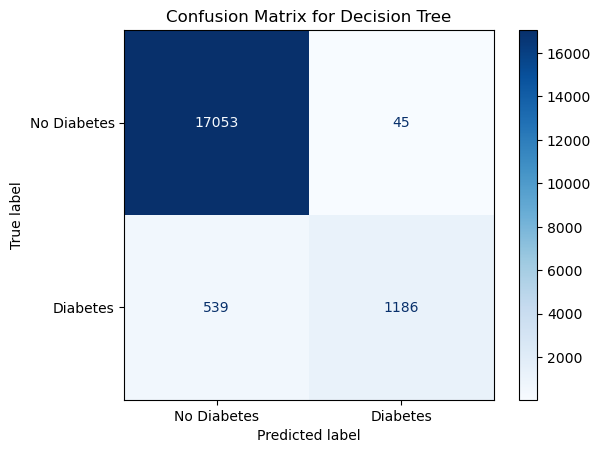


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17098
           1       0.96      0.69      0.80      1725

    accuracy                           0.97     18823
   macro avg       0.97      0.84      0.89     18823
weighted avg       0.97      0.97      0.97     18823

Accuracy: 0.97
Precision: 0.96
Recall: 0.69
F1 Score: 0.80


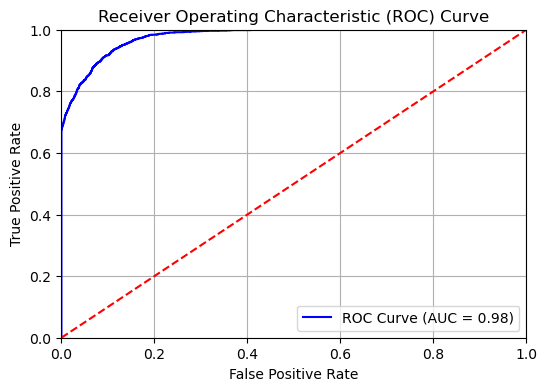

In [34]:
# Model Evaluation
xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_classifier.predict(X_test_scaled)

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix:")
print(conf_matrix_rf)

disp_xgb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb, 
                                  display_labels=['No Diabetes', 'Diabetes'])
disp_xgb.plot(cmap='Blues')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

# Results
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.2f}")

plot_roc_curve(xgb_classifier, X_test_scaled, y_test)

In [35]:
# Random Search

xgb_param_grid = {
    'n_estimators': [20, 50, 100],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
}

random_search_xgb = RandomizedSearchCV(xgb_classifier, xgb_param_grid, n_iter=5, cv=5, random_state=42, scoring='recall')
random_search_xgb.fit(X_train_scaled, y_train)

print("\nBest Parameters from RandomizedSearchCV:")
print(random_search_rf.best_params_)
print(f"Best Cross-Validation Score: {random_search_rf.best_score_:.2f}")


Best Parameters from RandomizedSearchCV:
{'n_estimators': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'criterion': 'entropy'}
Best Cross-Validation Score: 0.68


In [36]:
# Cross-Validation

best_xgb_classifier = random_search_xgb.best_estimator_
cv_scores = cross_val_score(best_xgb_classifier, X_train_scaled, y_train, cv=5, scoring='recall')

# Print cross-validation scores
print("Cross-Validation AUC Scores:", cv_scores)
print(f"Mean Cross-Validation AUC: {cv_scores.mean():.2f}")

Cross-Validation AUC Scores: [0.6841716  0.6760355  0.70318283 0.68911917 0.65433013]
Mean Cross-Validation AUC: 0.68


In [37]:
# Feature Importance

xgb_importance_df = get_feature_importance(best_xgb_classifier, X_train.columns)
xgb_importance_df

,Feature,Importance
0,HbA1c_level,0.563661
1,blood_glucose_level,0.267543
2,age,0.048430
3,hypertension,0.040851
4,heart_disease,0.036326
5,bmi,0.019383
6,smoking_history_non-smoker,0.010132
7,gender,0.009682
8,smoking_history_past_smoker,0.003992


#### 4.5 Catboost

Learning rate set to 0.065209
0:	learn: 0.5355480	total: 65.5ms	remaining: 1m 5s
1:	learn: 0.4478020	total: 72.3ms	remaining: 36.1s
2:	learn: 0.3636110	total: 79ms	remaining: 26.3s
3:	learn: 0.3046756	total: 85.7ms	remaining: 21.3s
4:	learn: 0.2472595	total: 91.5ms	remaining: 18.2s
5:	learn: 0.2184673	total: 98.2ms	remaining: 16.3s
6:	learn: 0.1951123	total: 105ms	remaining: 14.9s
7:	learn: 0.1763741	total: 111ms	remaining: 13.7s
8:	learn: 0.1624440	total: 117ms	remaining: 12.9s
9:	learn: 0.1477353	total: 123ms	remaining: 12.2s
10:	learn: 0.1393918	total: 130ms	remaining: 11.7s
11:	learn: 0.1309252	total: 136ms	remaining: 11.2s
12:	learn: 0.1243785	total: 143ms	remaining: 10.8s
13:	learn: 0.1196171	total: 149ms	remaining: 10.5s
14:	learn: 0.1157104	total: 156ms	remaining: 10.2s
15:	learn: 0.1120509	total: 162ms	remaining: 9.99s
16:	learn: 0.1082151	total: 169ms	remaining: 9.8s
17:	learn: 0.1055131	total: 177ms	remaining: 9.63s
18:	learn: 0.1039093	total: 185ms	remaining: 9.57s
19:	lear

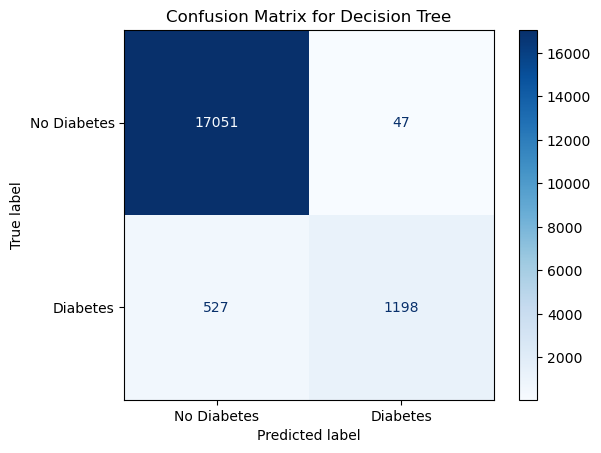


Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17098
           1       0.96      0.69      0.81      1725

    accuracy                           0.97     18823
   macro avg       0.97      0.85      0.90     18823
weighted avg       0.97      0.97      0.97     18823

Accuracy: 0.97
Precision: 0.96
Recall: 0.69
F1 Score: 0.81


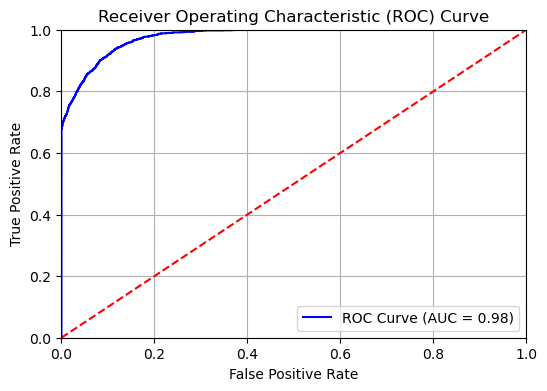

In [38]:
# Model Evaluation

cb_classifier = CatBoostClassifier(random_state=42)
cb_classifier.fit(X_train_scaled, y_train)

y_pred_cb = cb_classifier.predict(X_test_scaled)

# Confusion Matrix
conf_matrix_cb = confusion_matrix(y_test, y_pred_cb)
print("Confusion Matrix:")
print(conf_matrix_cb)

disp_cb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_cb, 
                                  display_labels=['No Diabetes', 'Diabetes'])
disp_cb.plot(cmap='Blues')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

# Results
print("\nClassification Report:")
print(classification_report(y_test, y_pred_cb))

print(f"Accuracy: {accuracy_score(y_test, y_pred_cb):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_cb):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_cb):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_cb):.2f}")

plot_roc_curve(cb_classifier, X_test_scaled, y_test)

In [39]:
# Random Search

cb_param_grid = {
    'iterations': [20, 50, 100],
    'depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0, 0.5, 1.0],
    'random_strength': [1, 2, 3]
}

random_search_cb = RandomizedSearchCV(cb_classifier, cb_param_grid, n_iter=8, cv=5, random_state=42, scoring='recall')
random_search_cb.fit(X_train_scaled, y_train)

print("\nBest Parameters from RandomizedSearchCV:")
print(random_search_cb.best_params_)
print(f"Best Cross-Validation Score: {random_search_cb.best_score_:.2f}")

0:	learn: 0.6087183	total: 2.99ms	remaining: 56.9ms
1:	learn: 0.5400953	total: 4.81ms	remaining: 43.3ms
2:	learn: 0.4830419	total: 6.62ms	remaining: 37.5ms
3:	learn: 0.4350992	total: 8.93ms	remaining: 35.7ms
4:	learn: 0.3941422	total: 10.9ms	remaining: 32.6ms
5:	learn: 0.3591304	total: 12.8ms	remaining: 29.8ms
6:	learn: 0.3290987	total: 14.5ms	remaining: 27ms
7:	learn: 0.3026721	total: 16.7ms	remaining: 25ms
8:	learn: 0.2794305	total: 18.4ms	remaining: 22.5ms
9:	learn: 0.2594489	total: 20.3ms	remaining: 20.3ms
10:	learn: 0.2420563	total: 22.3ms	remaining: 18.2ms
11:	learn: 0.2264312	total: 24.6ms	remaining: 16.4ms
12:	learn: 0.2125431	total: 26.3ms	remaining: 14.2ms
13:	learn: 0.2006057	total: 28.4ms	remaining: 12.2ms
14:	learn: 0.1895444	total: 30.8ms	remaining: 10.3ms
15:	learn: 0.1797341	total: 32.8ms	remaining: 8.21ms
16:	learn: 0.1710387	total: 35.3ms	remaining: 6.23ms
17:	learn: 0.1633002	total: 37.4ms	remaining: 4.15ms
18:	learn: 0.1560557	total: 39.3ms	remaining: 2.07ms
19:	lea

In [40]:
# Cross-Validation

best_cb_classifier = random_search_cb.best_estimator_
cv_scores = cross_val_score(best_cb_classifier, X_train_scaled, y_train, cv=5, scoring='recall')

# Print cross-validation scores
print("Cross-Validation AUC Scores:", cv_scores)
print(f"Mean Cross-Validation AUC: {cv_scores.mean():.2f}")

0:	learn: 0.5334765	total: 2.37ms	remaining: 234ms
1:	learn: 0.4269948	total: 4.11ms	remaining: 201ms
2:	learn: 0.3515895	total: 5.67ms	remaining: 183ms
3:	learn: 0.2961008	total: 7.34ms	remaining: 176ms
4:	learn: 0.2545524	total: 9.33ms	remaining: 177ms
5:	learn: 0.2231663	total: 10.9ms	remaining: 171ms
6:	learn: 0.2001248	total: 12.3ms	remaining: 164ms
7:	learn: 0.1825510	total: 13.7ms	remaining: 158ms
8:	learn: 0.1681549	total: 15.2ms	remaining: 154ms
9:	learn: 0.1561847	total: 16.8ms	remaining: 151ms
10:	learn: 0.1475849	total: 18.2ms	remaining: 148ms
11:	learn: 0.1387648	total: 19.6ms	remaining: 144ms
12:	learn: 0.1328967	total: 21.2ms	remaining: 142ms
13:	learn: 0.1277898	total: 22.6ms	remaining: 139ms
14:	learn: 0.1235998	total: 23.9ms	remaining: 135ms
15:	learn: 0.1203855	total: 25.3ms	remaining: 133ms
16:	learn: 0.1157380	total: 27.1ms	remaining: 132ms
17:	learn: 0.1123853	total: 28.5ms	remaining: 130ms
18:	learn: 0.1096936	total: 29.9ms	remaining: 128ms
19:	learn: 0.1079436	t

In [41]:
# Feature Importance

cb_importance_df = get_feature_importance(best_cb_classifier, X_train.columns)
cb_importance_df

,Feature,Importance
0,blood_glucose_level,41.519367
1,HbA1c_level,41.372924
2,age,10.469949
3,bmi,4.382624
4,hypertension,1.004804
5,heart_disease,0.680752
6,gender,0.381847
7,smoking_history_non-smoker,0.125960
8,smoking_history_past_smoker,0.061774
